In [1]:
import sys
print(sys.executable)

C:\Users\Paul5\anaconda3\envs\indicators\python.exe


In [11]:
import datetime

In [14]:
import talib
import bt
import pandas as pd
import matplotlib 
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


                  aapl        msft
Date                              
2010-01-04    6.431897   23.211439
2010-01-05    6.443017   23.218939
2010-01-06    6.340531   23.076445
2010-01-07    6.328810   22.836454
2010-01-08    6.370887   22.993946
...                ...         ...
2025-05-30  200.850006  460.359985
2025-06-02  201.699997  461.970001
2025-06-03  203.270004  462.970001
2025-06-04  202.820007  463.869995
2025-06-05  200.630005  467.679993

[3880 rows x 2 columns]


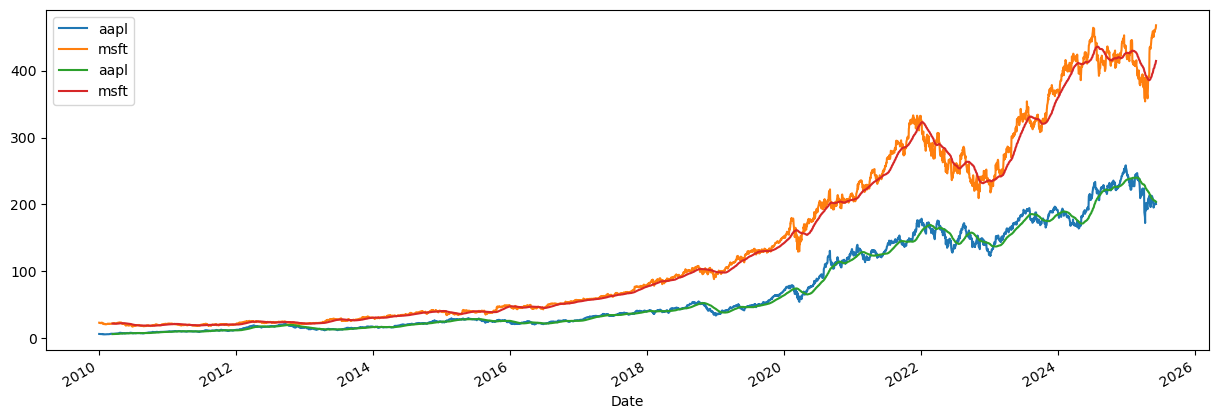

In [3]:
data = bt.get('aapl,msft', start='2010-01-01')
print(data)
# a rolling mean is a moving average, right?
sma = data.rolling(50).mean()
plot = bt.merge(data, sma).plot(figsize=(15, 5))

In [4]:
class SelectWhere(bt.Algo):

    """
    Selects securities based on an indicator DataFrame.

    Selects securities where the value is True on the current date (target.now).

    Args:
        * signal (DataFrame): DataFrame containing the signal (boolean DataFrame)

    Sets:
        * selected

    """
    def __init__(self, signal):
        self.signal = signal

    def __call__(self, target):
        # get signal on target.now
        if target.now in self.signal.index:
            sig = self.signal.loc[target.now]

            # get indices where true as list
            selected = list(sig.index[sig])

            # save in temp - this will be used by the weighing algo
            target.temp['selected'] = selected

        # return True because we want to keep on moving down the stack
        return True

100%|███████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.23s/it]


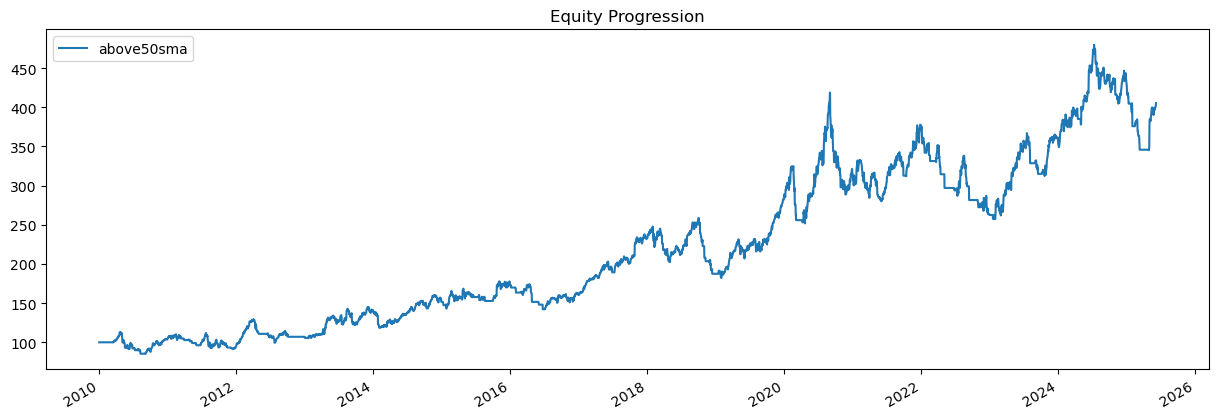

In [5]:
# first we create the Strategy
signal = data > sma
s = bt.Strategy('above50sma', [SelectWhere(data > sma),
                               bt.algos.WeighEqually(),
                               bt.algos.Rebalance()])

# now we create the Backtest
t = bt.Backtest(s, data)

# and let's run it!
res = bt.run(t)
res.plot();


In [6]:
res.display()

Stat                 above50sma
-------------------  ------------
Start                2010-01-03
End                  2025-06-05
Risk-free rate       0.00%

Total Return         305.32%
Daily Sharpe         0.57
Daily Sortino        0.87
CAGR                 9.50%
Max Drawdown         -38.59%
Calmar Ratio         0.25

MTD                  1.59%
3m                   11.52%
6m                   -6.10%
YTD                  -5.26%
1Y                   -3.29%
3Y (ann.)            10.93%
5Y (ann.)            6.40%
10Y (ann.)           9.76%
Since Incep. (ann.)  9.50%

Daily Sharpe         0.57
Daily Sortino        0.87
Daily Mean (ann.)    10.94%
Daily Vol (ann.)     19.18%
Daily Skew           -0.48
Daily Kurt           5.24
Best Day             7.63%
Worst Day            -7.99%

Monthly Sharpe       0.52
Monthly Sortino      0.96
Monthly Mean (ann.)  11.54%
Monthly Vol (ann.)   22.09%
Monthly Skew         -0.12
Monthly Kurt         -0.15
Best Month           15.99%
Worst Month          -

### Trend Indicators: 
Miden la direccion y fortaleza de la tendencia. Moving Avarega  (MA) and Average Directional Movement Index (ADX)

Diferencia entre SMA y EMA. Ema da mas peso a datos recientes mientras que la SMAda el mismo peso a todos los puntos de los datos.

[*********************100%***********************]  1 of 1 completed


                  aapl      EMA_12      EMA_26
Date                                          
2022-01-03  178.645615         NaN         NaN
2022-01-04  176.378357         NaN         NaN
2022-01-05  171.686737         NaN         NaN
2022-01-06  168.820709         NaN         NaN
2022-01-07  168.987534         NaN         NaN
...                ...         ...         ...
2025-05-30  200.850006  202.326222  203.944316
2025-06-02  201.699997  202.229880  203.778070
2025-06-03  203.270004  202.389899  203.740435
2025-06-04  202.820007  202.456069  203.672255
2025-06-05  200.630005  202.175136  203.446903

[859 rows x 3 columns]


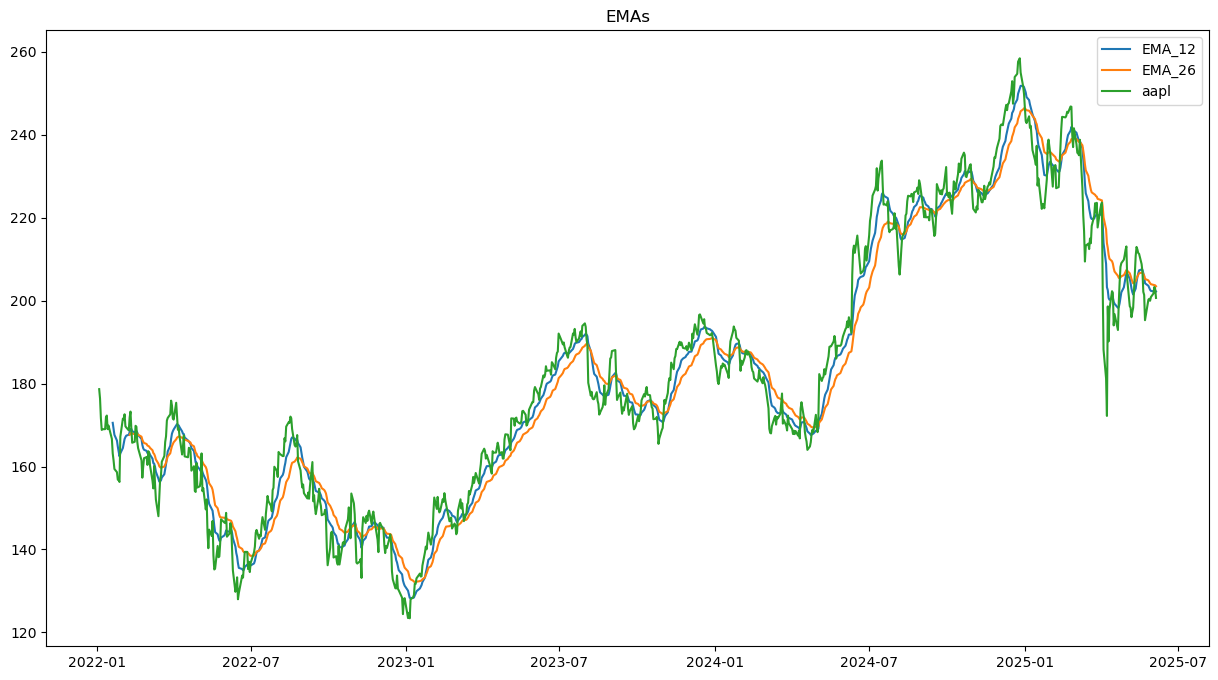

In [7]:
stock_data = bt.get('aapl', start='2022-01-01')
# Calculate 12-day EMA
stock_data['EMA_12'] = talib.EMA(stock_data['aapl'], timeperiod=12)
# Calculate 26-day EMA
stock_data['EMA_26'] = talib.EMA(stock_data['aapl'], timeperiod=26)
print(stock_data)

# Plot the EMAs with price
plt.figure(figsize=(15, 8))
plt.plot(stock_data['EMA_12'], label='EMA_12')
plt.plot(stock_data['EMA_26'], label='EMA_26')
plt.plot(stock_data['aapl'], label='aapl')

# Customize and show the plot
plt.legend()
plt.title('EMAs')
plt.show()

# ADX
 Mide la fuerza de una tendencia. Pero no muestra si es una tendencia alcista o bajista.
 ADX <= 25 : No tiene una tendencia clara
 ADX > 25 : Mercado en Tendencia
 ADX > 50 : Mercado con tendencia fuerte

 Mientras mas grande sea el timeperiod menos sensible sera el ADX a las fluctuaciones. Por ejemplo un trader que busca a largo plazo puede usar un time period mas grande.

Normalmente se lo grafica con el precio para ver como los cambios de este han pasado

In [8]:
stock_data2 = yf.Ticker("MSFT")
start_date = datetime(2022, 1, 1)
end_date = datetime.now() # O puedes especificar una fecha final fija

stock_data3 = stock_data2.history(start=start_date, end=end_date)
print(f"\nDatos históricos de MSFT (desde {start_date.strftime('%Y-%m-%d')} hasta {end_date.strftime('%Y-%m-%d')}):")
print(stock_data3.head())


Datos históricos de MSFT (desde 2022-01-01 hasta 2025-06-05):
                                 Open        High         Low       Close  \
Date                                                                        
2022-01-03 00:00:00-05:00  325.620684  328.193796  320.212277  325.038086   
2022-01-04 00:00:00-05:00  325.115755  325.475046  316.658462  319.464630   
2022-01-05 00:00:00-05:00  316.405930  316.609859  306.812600  307.200989   
2022-01-06 00:00:00-05:00  304.064728  309.453726  302.452885  304.773560   
2022-01-07 00:00:00-05:00  305.035688  307.317515  301.093482  304.928894   

                             Volume  Dividends  Stock Splits  
Date                                                          
2022-01-03 00:00:00-05:00  28865100        0.0           0.0  
2022-01-04 00:00:00-05:00  32674300        0.0           0.0  
2022-01-05 00:00:00-05:00  40054300        0.0           0.0  
2022-01-06 00:00:00-05:00  39646100        0.0           0.0  
2022-01-07 00:00:00

                                 Open        High         Low       Close  \
Date                                                                        
2025-05-30 00:00:00-04:00  459.720001  461.679993  455.540009  460.359985   
2025-06-02 00:00:00-04:00  457.140015  462.109985  456.890015  461.970001   
2025-06-03 00:00:00-04:00  461.470001  464.140015  460.859985  462.970001   
2025-06-04 00:00:00-04:00  464.000000  465.690002  463.019989  463.869995   
2025-06-05 00:00:00-04:00  464.959991  469.649994  464.029999  467.679993   

                             Volume  Dividends  Stock Splits     ADX_14  \
Date                                                                      
2025-05-30 00:00:00-04:00  34770500        0.0           0.0  38.169723   
2025-06-02 00:00:00-04:00  16626500        0.0           0.0  38.386138   
2025-06-03 00:00:00-04:00  15743800        0.0           0.0  38.758386   
2025-06-04 00:00:00-04:00  14162700        0.0           0.0  39.234762   
2025-06-05

NameError: name 'mdates' is not defined

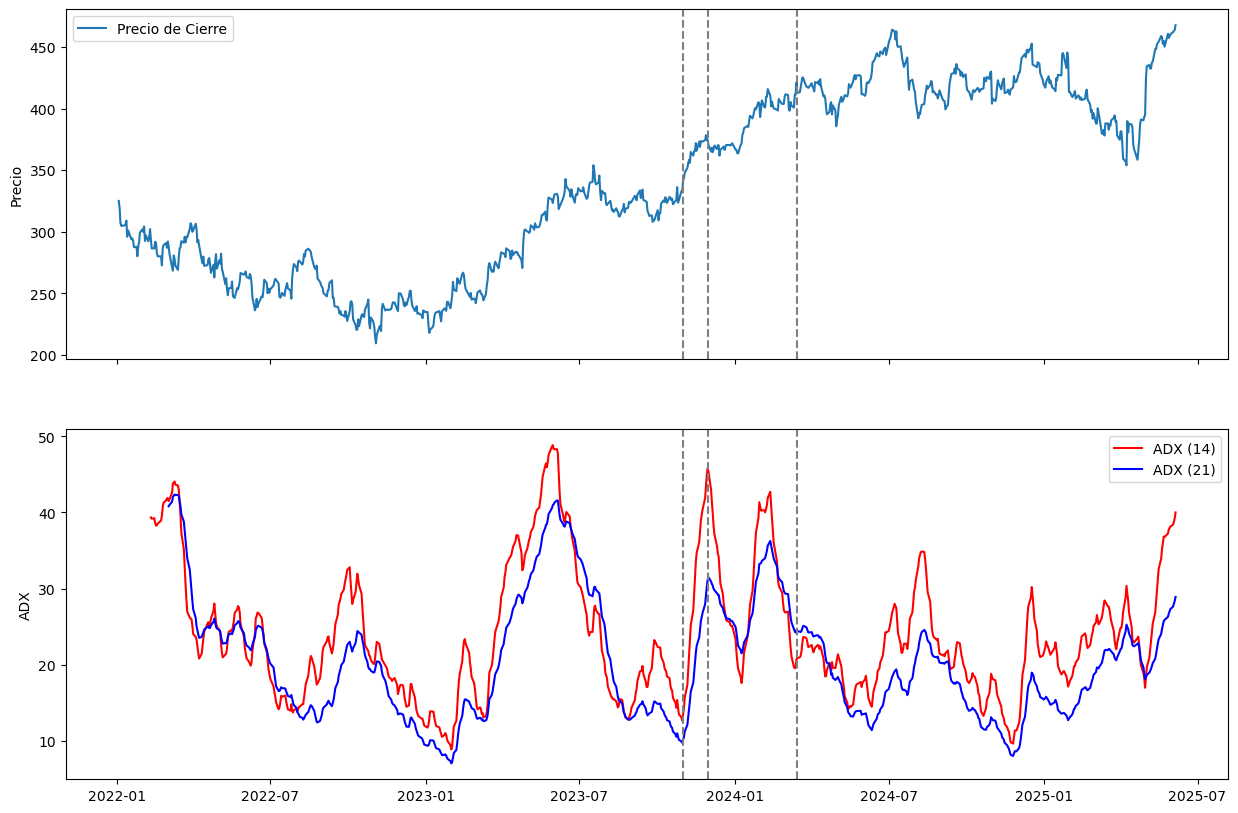

In [9]:
# Calculate the ADX with the default time period
stock_data3['ADX_14'] = talib.ADX(stock_data3['High'],
                            stock_data3['Low'], 
                            stock_data3['Close'])

# Calculate the ADX with the time period set to 21
stock_data3['ADX_21'] = talib.ADX(stock_data3['High'],
                            stock_data3['Low'], 
                            stock_data3['Close'], timeperiod=21)

# Print the last five rows
print(stock_data3.tail())

## Ajustar el Tamaño de los Subplots
fig, (ax1, ax2) = plt.subplots(2, figsize=(15, 10), sharex=True) # sharex=True para que ambos ejes x estén sincronizados

# Plot ADX with the price
ax1.set_ylabel('Precio')
ax1.plot(stock_data3['Close'], label='Precio de Cierre')
ax1.legend() # Mostrar leyenda en ax1

ax2.set_ylabel('ADX')
ax2.plot(stock_data3['ADX_14'], color='red', label='ADX (14)')
ax2.plot(stock_data3['ADX_21'], color='blue', label='ADX (21)') # Plotear también ADX_21
ax2.legend() # Mostrar leyenda en ax2

# ---
## Trazar Líneas Verticales en Fechas Específicas

# Define las fechas donde quieres trazar las líneas verticales
# Asegúrate de que las fechas estén en formato datetime
vertical_lines_dates = [
    datetime(2023, 11, 1), # Ejemplo: 1 de junio de 2022
    datetime(2023, 12, 1), # Ejemplo: 1 de enero de 2023
    datetime(2024, 3, 15) # Ejemplo: 15 de marzo de 2024
]

# Itera sobre las fechas y dibuja una línea vertical en cada subplot
for date in vertical_lines_dates:
    ax1.axvline(x=date, color='gray', linestyle='--', linewidth=1.5, label=f'Línea vertical {date.year}')
    ax2.axvline(x=date, color='gray', linestyle='--', linewidth=1.5) # No repetir la etiqueta en el segundo subplot


## Mejoras en el Eje X (Inclinación y Formato de Meses)

# Aplicar el formato de fechas a ambos subplots (gracias a sharex=True, basta con ax2)
# Configurar los localizadores de fechas (para mostrar ticks en cada mes, por ejemplo)
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=1)) # Muestra un tick cada mes
ax2.xaxis.set_minor_locator(mdates.DayLocator(interval=1)) # Ticks menores cada día (opcional, para zoom)
ax2.axhline(y=25, color='green', linestyle=':', linewidth=2, label='Umbral ADX (25)')
ax2.legend() # Actualiza la leyenda para incluir la nueva línea

# Formatear las etiquetas del eje X
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y')) # 'Mes AAAA' (ej. 'Ene 2022')

# Inclinar las etiquetas del eje X
fig.autofmt_xdate(rotation=45) # Inclina las etiquetas 45 grados

# Ajustes de títulos y etiquetas
ax1.set_title('Precio de MSFT y ADX')
ax2.set_xlabel('Fecha') # Etiqueta del eje X solo en el subplot inferior
plt.tight_layout() # Ajusta el diseño para evitar superposiciones
plt.show()

# Momentum

Es la velocidad de subida o bajada de los precios.

RSI > 70 : Un mercado sobrevalorado que indica que el precio podria revertirse.
RSI < 30 : COndicion de sobreventa lo que significa que esta subvaluado y el precio podria subir.


 Ten en cuenta que cuanto mas larga sea el timeperiod, menos sensible sera a las fluctuaciones del precio.

 

                                 Open        High         Low       Close  \
Date                                                                        
2022-01-03 00:00:00-05:00  325.620684  328.193796  320.212277  325.038086   
2022-01-04 00:00:00-05:00  325.115755  325.475046  316.658462  319.464630   
2022-01-05 00:00:00-05:00  316.405930  316.609859  306.812600  307.200989   
2022-01-06 00:00:00-05:00  304.064728  309.453726  302.452885  304.773560   
2022-01-07 00:00:00-05:00  305.035688  307.317515  301.093482  304.928894   

                             Volume  Dividends  Stock Splits  ADX_14  ADX_21  \
Date                                                                           
2022-01-03 00:00:00-05:00  28865100        0.0           0.0     NaN     NaN   
2022-01-04 00:00:00-05:00  32674300        0.0           0.0     NaN     NaN   
2022-01-05 00:00:00-05:00  40054300        0.0           0.0     NaN     NaN   
2022-01-06 00:00:00-05:00  39646100        0.0           0.0

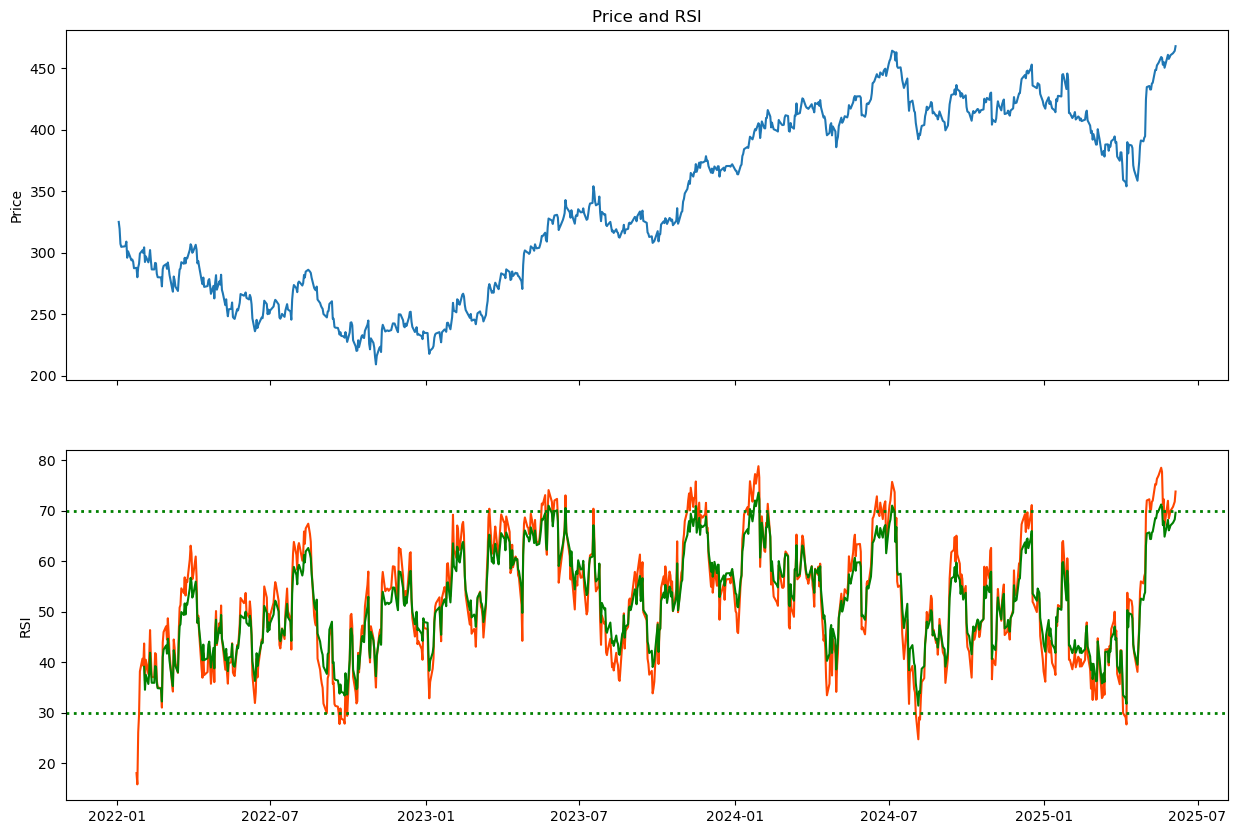

In [12]:
# Calculate RSI with the default time period
stock_data3['RSI_14'] = talib.RSI(stock_data3['Close'])

# Calculate RSI with a time period of 21
stock_data3['RSI_21'] = talib.RSI(stock_data3['Close'],timeperiod=21)

# Print the last five rows
print(stock_data3.head())


# Create subplots
fig, (ax1, ax2) = plt.subplots(2, figsize=(15, 10), sharex=True)
# Plot RSI with the price
ax1.set_ylabel('Price')
ax1.plot(stock_data3['Close'])
ax2.set_ylabel('RSI')
ax2.plot(stock_data3['RSI_14'], color='orangered')
ax2.plot(stock_data3['RSI_21'], color='green')

ax2.axhline(y=30, color='green', linestyle=':', linewidth=2, label='RSI 30')
ax2.axhline(y=70, color='green', linestyle=':', linewidth=2, label='RSI 70')

ax1.set_title('Price and RSI')
plt.show()

# Volatility

Bollinger Bands: Measure price volatility
tres lineas: la del medio es una SMA, la de arriba la desviasion estandar arriba de la SMA, y la otra la desviation standar abajo de la linea del medio.

Por ejemplo un trader puede escoger una media SMA de 10 y desviaciones estandares de 1.5 para un corto plazo. O una sma 50 y 2.5 para una estrategia a largo plazo.

Mientras mas anchas sean las bandas hay mas volatiladad en lso precios de los activos.

Estadisticamente hablado si las bandsa superiores e inferio se basan en 1 deviacion estandar contienen alrederos del 68% de los movimientos de los precios recientes. Si las desviaciones son 2 contienen aproximadamente el 95% de los moviemientos recientes del precio. solo se mueve fuera del precio en el 5% de los casos si se usa 95% de confianza.

Si el precio esta cerca de la banda superior es relativamente caro, y barato cuando esta cerca de la banda inferior.

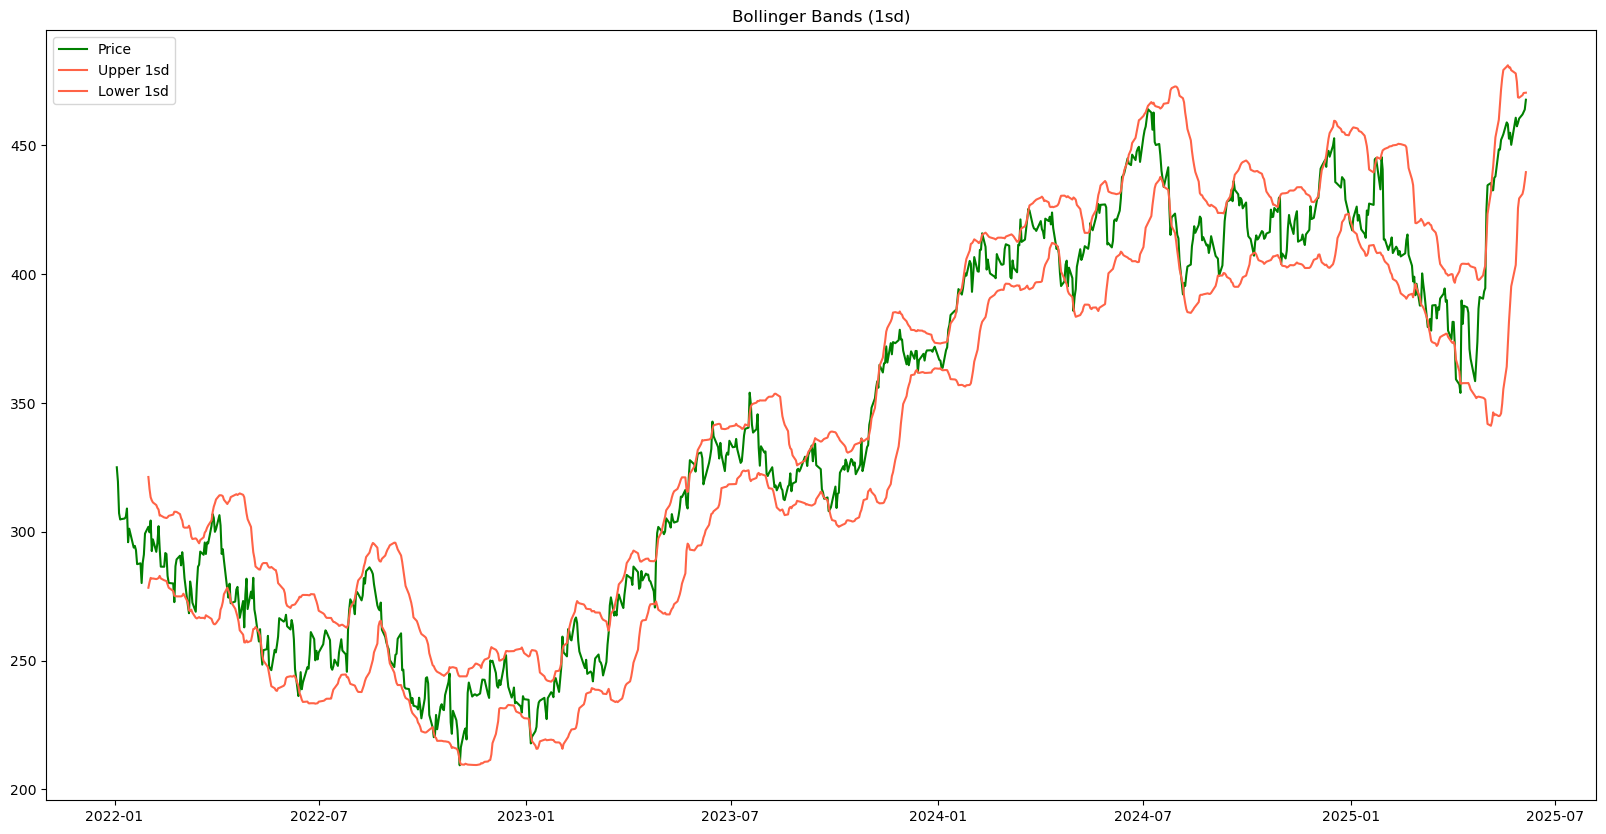

In [13]:
# Define the Bollinger Bands with 1-sd
upper_1sd, mid_1sd, lower_1sd = talib.BBANDS(stock_data3['Close'], 
                                     nbdevup = 2,
                                     nbdevdn = 2,
                                     timeperiod=20)
# Plot the upper and lower Bollinger Bands 
plt.figure(figsize=(20, 10))
plt.plot(stock_data3['Close'], color='green', label='Price')
plt.plot(upper_1sd, color='tomato', label="Upper 1sd")
plt.plot(lower_1sd, color='tomato', label='Lower 1sd')

# Customize and show the plot
plt.legend(loc='upper left')
plt.title('Bollinger Bands (1sd)')
plt.show()